In [1]:
import pandas as pd
import numpy as np

from binarytree import Node
from collections import deque
from typing import List, Set

# necessary to allow RAGs to be inserted in nodes
#binarytree._NODE_VAL_TYPES = (float, int, str, list)

In [294]:
cognate = pd.read_csv("Grollemund_Data_Cognate.csv", index_col=0)
phonetic = pd.read_csv("Grollemund_Data_Phoneme.csv", index_col=0)
features = pd.read_csv("Chomsky_Halle_Features.csv", index_col=0)
 
clade_file = open('Clades.txt', 'r').readlines()
clades = {i.split(',')[0] : [j.strip() for j in i.split(',')[1:]] for i in clade_file}

indel = "indel"

In [361]:
all_phonemes = list(features.columns)[0:]

feature_matrix = pd.DataFrame(0, index=all_phonemes, columns=all_phonemes)

for phoneme1 in all_phonemes:
    for phoneme2 in all_phonemes:
        for (f, g) in zip(features.loc[:,phoneme1], features.loc[:,phoneme2]):
            if(not pd.isnull(f) and not pd.isnull(g) and f != g):
                #basically gets the Manhattan distance between two feature vectors
                feature_matrix.loc[phoneme1, phoneme2] += 1
feature_matrix
# the dataframe looks nicer, but using a dictionary is several times faster in the actual function
feature_matrix = feature_matrix.to_dict() 

In [364]:
from collections import defaultdict
from typing import List, Optional
from scipy.spatial.distance import pdist, squareform

class CognateDistance:
    
    def __init__(self, difference_cost: float = 1.):
        self._difference_cost = difference_cost
    
    def __call__(self, source: str, target: str) -> float:
        return 0. if (source == target) else self._difference_cost
    
    #def common_words(self, lang1: str, lang2: str):
        #pri
    
    def distance_matrix(self, word: str) -> pd.core.frame.DataFrame:
        strings = np.array(list(cognate.loc[:,word]), dtype=object).reshape(-1,1)
        
        matrix = pdist(strings, lambda x, y: self(x[0], y[0]))
        #square_matrix = pd.DataFrame(squareform(matrix), columns=cognate.index, index=cognate.index).rename_axis(index=None)

        return matrix
    
    def full_distance_matrix(self, phonemes: List[str]) -> np.array:
        
        full_matrix = np.zeros(int(len(cognate.index) ** 2 / 2 - len(cognate.index) / 2))
        for word in cognate.columns:
            full_matrix = np.add(full_matrix, self.distance_matrix(word))
            print(word)
        return full_matrix
    
class StringDistance:
    '''Distance between strings


    Parameters
    ----------
    insertion_cost
    deletion_cost
    substitution_cost
    '''
    
    def __init__(self, insertion_cost: float = 1.,
                 deletion_cost: float = 1., cost_matrix: Optional[pd.DataFrame] = None):
        self._insertion_cost = insertion_cost
        self._deletion_cost = deletion_cost

    def __call__(self, source: str, target: str) -> float:
        return self._wagner_fisher(source, target)
    
    def string_to_phonemes(self, string: str, phonemes: List[str]) -> List[str]:
        ordered_phonemes = list(sorted(phonemes, key = len))
        ordered_phonemes.reverse() # this gets a list where the longest multigraphs appears first
        
        '''
        The data is formatted so that the class prefix is separated by a hyphen. 
        This should get the main roots whether these is
        '''
        
        stem = string.split('-')
        
        if(len(stem) > 1):
            string = stem[1]
        else:
            string = stem[0]
        
        phoneme_list = list()
        i = 0
        while(i < len(string)):
            for p in ordered_phonemes:
                if(len(string) - i >= len(p) and string[i:i + len(p)] == p):
                    phoneme_list.append(p)
                    i += len(p)
                    break
                #if any character isn't part of the list of phonemes, ignore it
                elif(i < len(string) and string[i] not in phonemes):
                    i += 1
                    break
        return phoneme_list
    '''
    based on the implementation found here:    
    https://www.codeproject.com/Articles/5342019/An-Optimal-Wagner-Fischer-Algorithm-For-Approximat
    '''
    def _wagner_fisher(self, source: List[str], target: List[str]):
        
        # returns a distance of zero if source and target are equal
        n, m = len(source), len(target)
        
        if source == target: 
            return 0
        elif source == []:
            return n * self._insertion_cost
        elif target == []:
            return m * self._insertion_cost
        
        e_d = np.zeros([m], dtype=float)
        
        for i in range(1, n):
            e_i = np.concatenate(([i], np.zeros(m - 1, dtype=float)), axis=0)
            
            for j in range(1, m):
            
                if source[i] == target[j]:
                    substitution_cost = 0.
                else:
                    substitution_cost = feature_matrix[source[i]][target[j]]
                    
                e_i[j] = min(e_d[j] + self._deletion_cost,
                                  e_i[j - 1] + self._insertion_cost,
                                  e_d[j - 1] + substitution_cost)
            e_d = np.array(e_i, copy=True)
                    
        
        # adjusts the distance by dividing by the length on the longest lexical item
        return e_d[len(e_d) - 1] / max(len(source), len(target))
    
    def distance_matrix(self, word: str, phonemes: List[str], square: bool = False) -> pd.core.frame.DataFrame:
        strings = [self.string_to_phonemes(i, phonemes) for i in list(phonetic.loc[:,word])]
        strings = np.array(strings, dtype=object).reshape(-1,1)
        
        matrix = pdist(strings, lambda x, y: self(x[0], y[0]))
        
        if(square):
            return self.square_matrix(matrix)
        else:
            return matrix
        
    def square_matrix(self, matrix: np.array) -> pd.core.frame.DataFrame:
        return pd.DataFrame(squareform(matrix), columns=phonetic.index, index=phonetic.index).rename_axis(index=None)
            
    def full_distance_matrix(self, phonemes: List[str]) -> np.array:
        full_matrix = np.zeros(int(len(phonetic.index) ** 2 / 2 - len(phonetic.index) / 2))
        for word in phonetic.columns:
            full_matrix = np.add(full_matrix, self.distance_matrix(word, phonemes))
            print(word) #this allows
        return full_matrix

In [365]:
stringdist = StringDistance(1, 1, feature_matrix)
#cognatedist = CognateDistance()

#len(stringdist.distance_matrix('ashes', all_phonemes))

test = stringdist.full_distance_matrix(all_phonemes)
#test2 = cognatedist.full_distance_matrix(all_phonemes)

#test.add(test, fill_value=0)
#test

animal
arm
ashes
bark
bed
belly
big
bird
bite
blood
bone
breast
burn
child
cloud
come
count
die
dog
drink
ear
eat
egg
elephant
eye
face
fall
fat, oil
feather
fingernail
fire
fire-wood
fish
five
fly
four
give
goat
ground, soil
hair
head
hear
heart
horn
house
hunger
intestine
kill
knee
knife
know
leaf
leg
liver
louse
man
moon
mouth
name
navel
neck
night
nose
one
person
rain
road
root
salt
sand
see
send
shame
sing
skin
sky
sleep
smoke
snake
spear
steal
stone
sun
tail
ten
three
tongue
tooth
tree
two
urine
village
vomit
walk
war
water
wind
woman
dew
iron


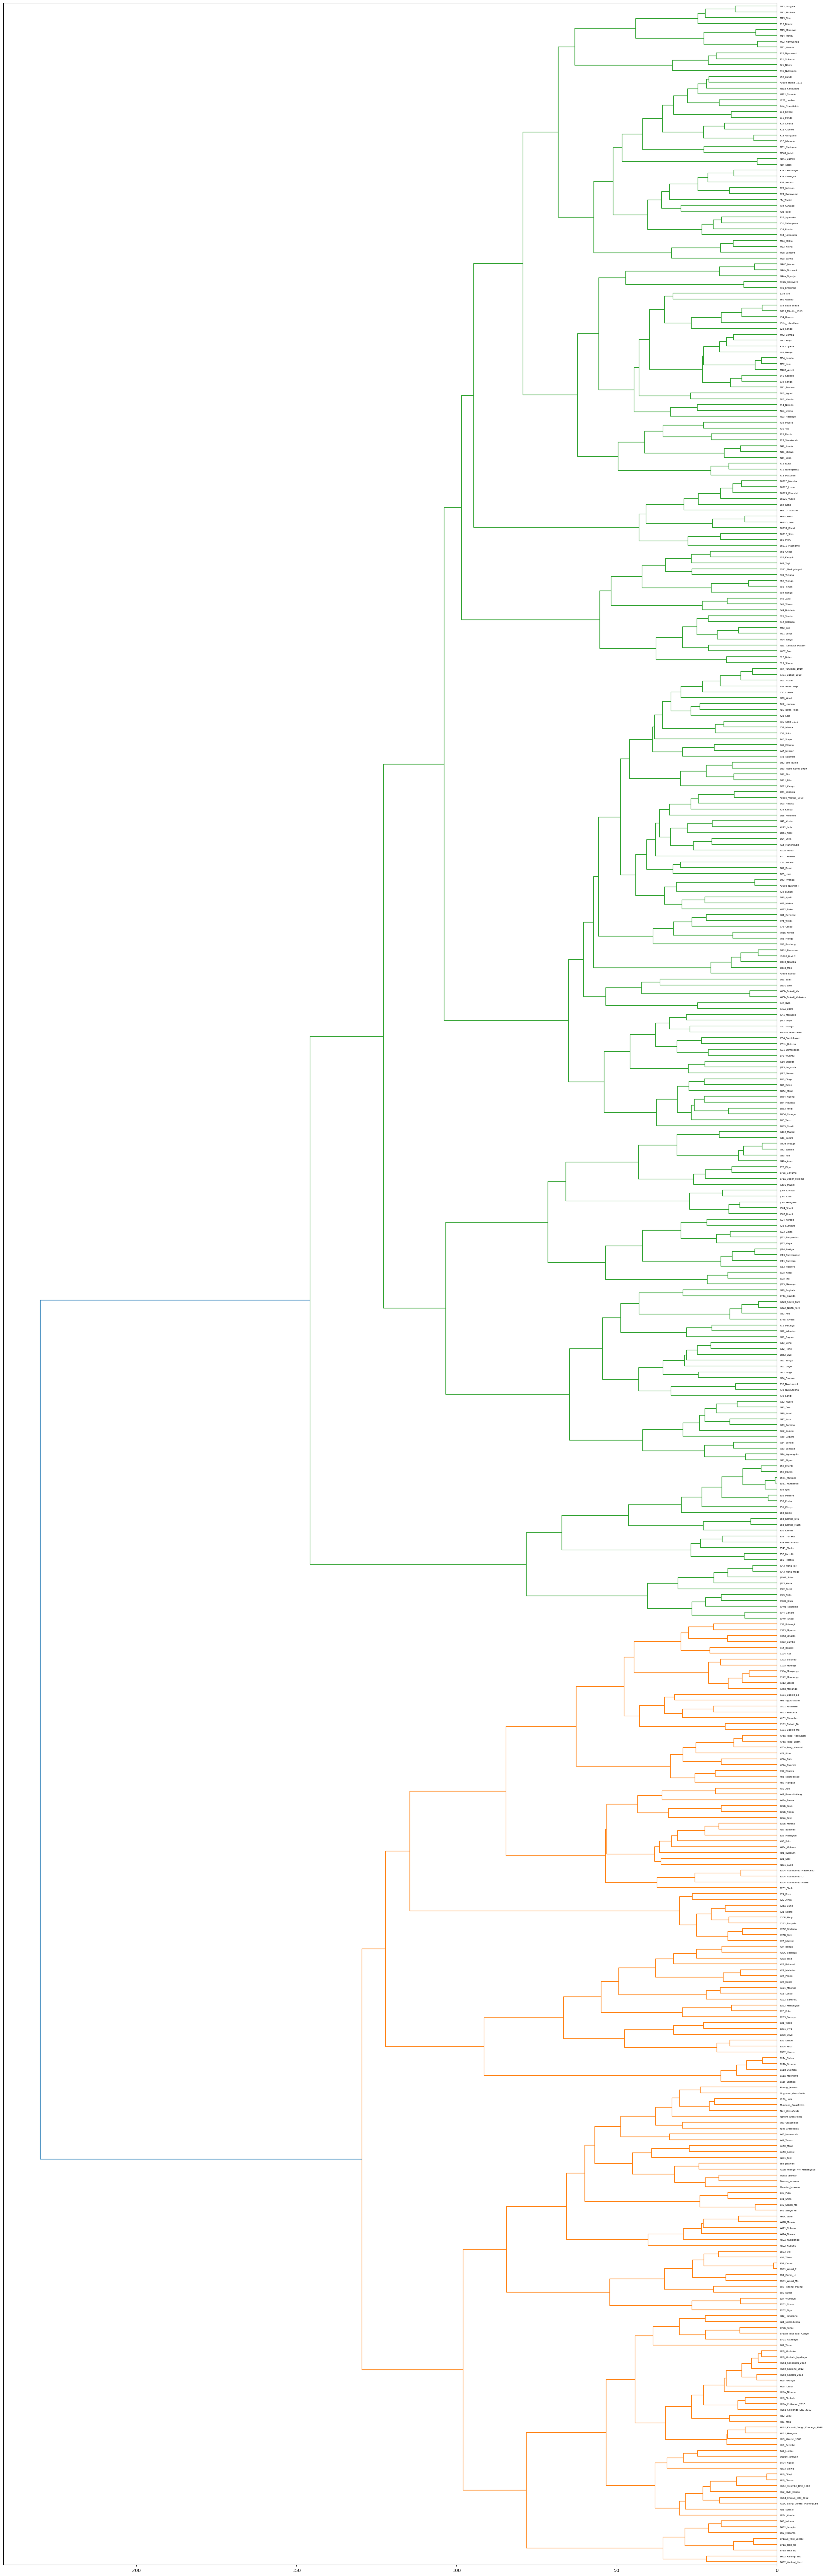

Tree score: 0.15


In [366]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
from scipy.cluster.hierarchy import linkage, dendrogram, to_tree

clust = linkage(np.nan_to_num(test), method='ward')
correct_index = phonetic

ax = plt.subplots(figsize=(30, 100))
ax = dendrogram(clust, orientation='left', labels=[i for i in correct_index.index])
plt.show()

tree = to_tree(clust)

def print_tree(node):
    #if(not node.right and not node.left):
        #print(cognate.index[node.id])
    #else:
    if(node.id < len(cognate.index)):
        print(cognate.index[node.id])
    else:
        print(node.id)
    if(node.right):
        print_tree(node.right)
    if(node.left):
        print_tree(node.left)

def search_for_clade(tree, name, clade):
    _max = []
    search_clade_recurs(tree, name, clade, _max)
    node = max(_max, key=lambda x:x[1])[0] # gets the node with the max depth
    return node.pre_order(lambda x: correct_index.index[x.id])
    
def search_clade_recurs(node, name, clade, _list, depth=0):
    if not node:
        return None
    
    if(sum(i in node.pre_order(lambda x: correct_index.index[x.id]) for i in clade) >= len(clade) * ((len(clade) - 1) / len(clade))):
        _list.append((node, depth))
        if set(node.pre_order(lambda x: correct_index.index[x.id])) != set(clades[name]):
            search_clade_recurs(node.left, name, clade, _list, depth + 1)
            search_clade_recurs(node.right, name, clade, _list, depth + 1)
        
    return None

def score_tree(tree, weigh=True, print_clades=False):
    score = 0
    total = 0
    claded_langs = [i for l in clades.values() for i in l] # only includes languages that are placed within a clade
    for clade in clades:
        test = search_for_clade(tree, clade, clades[clade])
        missing_langs = len([l for l in clades[clade] if l not in test])
        spurious_langs = len([l for l in test if l not in clades[clade] and l in claded_langs])
        clade_score = max(0, 1 - (min(1, spurious_langs / len(clades[clade])) + missing_langs / len(clades[clade])))
        if(weigh):
            score += clade_score * len(clades[clade])
        else:
            score += clade_score
        if(print_clades):
            print(clade + ": " + str(round(clade_score, 2)))
    
    if(weigh):
        print("Tree score: " + str(round(score / len(claded_langs), 2)))
    else:
        print("Tree score: " + str(round(score / len(clades.values()), 2)))

score_tree(tree)

In [131]:
'''
class DO:
    
    def __init__(self, a, b, sub):
        self.a = a
        self.b = b
        self.sub = sub
        self.X = []
        self.Y = []
        
        A = []
        B = [] 
         
    def subst(self, X: Set, Y: Set):
        if(X.intersection(Y)):
            return 0
        else:
            return self.sub

    def diag(self, X: Set, Y: Set) -> float:
        if(indel in X and indel in Y):
            return 0
        else:
            return np.inf

    def go(self, A: List, i: int) -> float:
        if((i == 0 or (i > 0 and indel not in A[i - 1])) and indel in A[i]):
            return 0
        else:
            return self.a

    def goPrime(self, X: Set, Y: Set) -> float:
        if(indel not in X):
            return self.subst(X, Y)
        else:
            return self.subst(X, Y) + self.a

    def ge(self, X: Set) -> float:
        if(indel in X):
            return 0
        else:
            return self.b

    def g(self, i, j):
        if(i < 0 and j < 0):
            return 0
        elif(i < 0 or j < 0):
            return np.inf
        else:
            return min(self.g(i - 1, j - 1) + self.subst(self.A[i], self.B[j]),
                       self.d(i - 1, j - 1) + self.subst(self.A[i], self.B[j]) + self.go(self.A, i) + self.go(self.B, j),
                       self.v(i - 1, j - 1) + self.goPrime(self.B[j], self.A[i]),
                       self.h(i - 1, j - 1) + self.goPrime(self.A[i], self.B[j]))

    def h(self, i, j):
        if(i < 0 and j < 0):
            return self.go(self.B, 0)
        elif(i < 0):
            return self.h(-1, j - 1) + self.ge(self.B[j])
        elif(j < 0):
            return np.inf
        else:
            return min(self.h(i, j - 1) + self.ge(self.B[j]), self.d(i, j - 1) + self.ge(self.B[j]) + self.go(self.B, j))

    def v(self, i, j):
        if(i < 0 and j < 0):
            return self.go(self.A, 0)
        elif(i < 0):
            return np.inf
        elif(j < 0):
            return self.v(i - 1, -1) + self.ge(self.A[i])
        else:
            return min(self.v(i - 1, j) + self.ge(self.A[i]), self.d(i - 1, j) + self.ge(self.A[i]) + self.go(self.A, i))

    def d(self, i, j):
        if(i < 0 or j < 0):
            return np.inf
        else:
            return diag(self.A[i], self.B[j]) + min(self.d(i - 1, j - 1), self.g(i - 1, j - 1) + 
                                                    self.go(self.A, i) + self.go(self.B, j))

    def eaffp(self, nA: List, nB: List) -> float:
        self.A = nA
        self.B = nB
        self.X = [set() for i in range(0, len(nA))]
        self.Y = [set() for i in range(0, len(nB))]
        i = len(nA) - 1
        j = len(nB) - 1
        return min(self.g(i, j), self.h(i, j), self.v(i, j), self.d(i, j))

    def maffp(self, nA: List, nB: List) -> List:
        M = []
       # for k in range(0, max(len(A), len(B))):
            #if(X[k] == indel and Y[k])
    

def reverseLevelOrder(root):
    levels = [[] for i in range(0, root.height + 1)]
    queue = deque()
    queue.append((root, 0))

    while queue:
        n = queue.popleft()
 
        if(not levels[root.height - n[1]]):
            levels[root.height - n[1]] = [n[0]]
        else:
            levels[root.height - n[1]].append(n[0])
        
        if n[0].right or n[0].left:
            queue.append((n[0].right, n[1] + 1))
            queue.append((n[0].left, n[1] + 1))
    
    return levels

def string_to_RAG(s: str) -> List[Set]:
    return [set(c) for c in s]

def affine_DO(T: Node):
    for level in reverseLevelOrder(T):
        for node in level:
            if(node.right and node.left):
                print()

def wagner(languages: List[str]):
    T = Node("")
    L = [Node(l) for l in languages]
    for i in range(len(L)):
        c = np.inf
        print(i)
'''

'\nclass DO:\n    \n    def __init__(self, a, b, sub):\n        self.a = a\n        self.b = b\n        self.sub = sub\n        self.X = []\n        self.Y = []\n        \n        A = []\n        B = [] \n         \n    def subst(self, X: Set, Y: Set):\n        if(X.intersection(Y)):\n            return 0\n        else:\n            return self.sub\n\n    def diag(self, X: Set, Y: Set) -> float:\n        if(indel in X and indel in Y):\n            return 0\n        else:\n            return np.inf\n\n    def go(self, A: List, i: int) -> float:\n        if((i == 0 or (i > 0 and indel not in A[i - 1])) and indel in A[i]):\n            return 0\n        else:\n            return self.a\n\n    def goPrime(self, X: Set, Y: Set) -> float:\n        if(indel not in X):\n            return self.subst(X, Y)\n        else:\n            return self.subst(X, Y) + self.a\n\n    def ge(self, X: Set) -> float:\n        if(indel in X):\n            return 0\n        else:\n            return self.b\n\n